In [1]:
import sys
import os
import cvxpy as cp
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('.'))
os.environ['MOSEKLM_LICENSE_FILE'] = module_path
import mosek

from ControlRF import KernelGP, RandomFeaturesADPGP, RandomFeaturesGP

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/core")

import core
from core.controllers import QPController
from core.dynamics import AffineDynamics, AffineQuadCLF, ScalarDynamics, SystemDynamics
from core.util import arr_map
from core.controllers import FBLinController, LQRController
from core.systems import InvertedPendulum


In [2]:
class ADPGPController(QPController):
    def __init__(self, system_est, system, controller, aff_lyap, x_0, T, num_steps, estimate):
        QPController.__init__(self, system_est, system_est.m)
        xs, us, ts = ADPGPController._simulate(system, controller, x_0, T, num_steps)
        xs, ys, zs = ADPGPController._build_ccf_data(aff_lyap,xs,us,ts) #ts=ts[1:-1]
        self.gp = ADPGPController._train_gp(xs, ys, zs, estimate)
        print("----------------------------training finished------------------------------")
    
    @staticmethod
    def _simulate(system, controller, x_0, T, num_steps):
        '''simulate system with specified controller'''
        ts = np.linspace(0, T, num_steps)
        xs, us = system.simulate(x_0, controller, ts)
        return xs, us, ts

    @staticmethod
    def _build_ccf_data(aff_lyap,xs,us,ts):
        ''' estimate error in the derivate of the CCF function
        using forward differencing '''
        av_x = (xs[:-1] + xs[1:])/2
        zs= [aff_lyap.eval(xs[i+1],ts[i+1])- aff_lyap.eval(xs[i],ts[i]) - \
        aff_lyap.eval_dot(av_x[i],us[i],ts[i]) for i in range(len(us))]
        ys = np.concatenate((np.ones((len(us),1)), us), axis=1)
        return av_x, ys, zs
    
    @staticmethod
    def _train_gp(xs, ys, zs, estimate):
        '''training for GP'''
        if estimate:
            gp = RandomFeaturesGP(xs, ys, zs) 
            #RandomFeaturesADPGP(xs, ys, zs)
            gp.train()
            #gp.c_train()
        else:
            gp = KernelGP(xs, ys, zs)
            gp.train()
            gp.c_train()        
        return gp
    
    def add_stability_constraint(self,aff_lyap, comp=0, slacked=False, beta=1):
        if slacked:
            delta = cp.Variable()
            self.variables.append(delta)
            self.static_costs.append(cp.square(delta)) #might need to add coef
            constraint = lambda x,t :  self._build_cons(x, t, aff_lyap, comp, beta, delta)
        else:
            constraint = lambda x,t :  self._build_cons(x, t, aff_lyap, comp, beta)
        self.constraints.append(constraint)

    def _build_cons(self, x, t, aff_lyap, comp, beta, delta=0):
        mv, sv = self.gp.mean_var([x]), self.gp.sigma_var() #m+1, (m+1,m+1)
        input_dep = -(aff_lyap.act(x,t) + mv[1:]) #m
        input_indep = delta -(aff_lyap.drift(x,t) + mv[0] + comp * aff_lyap.eval(x,t)) #()
        #print(input_dep.shape, input_indep.shape, mv.shape, sv.shape, sv[1:].shape, sv[0].shape)
        return cp.SOC(input_dep @ self.u.T + input_indep, beta * sv[1:].T @ self.u + beta * sv[0].T)

    def eval(self, x ,t):    
        static_cost = cp.sum(self.static_costs)
        dynamic_cost = cp.sum([cost(x, t) for cost in self.dynamic_costs])
        obj = cp.Minimize(static_cost + dynamic_cost)
        cons = [constraint(x, t) for constraint in self.constraints]
        prob = cp.Problem(obj, cons)
        prob.solve(solver = 'MOSEK', warm_start=True)
        return self.u.value, [variable.value for variable in self.variables]
    
    def process(self, u):
        u, _ = u
        if u is None:
            u = np.zeros(self.m)
        return u

In [3]:
def plot_simulation(system, controller, x_0,
					T=20, num_steps=200):
	ts = np.linspace(0, T, num_steps + 1)
	xs, us = system.simulate(x_0, controller, ts)

	ax = plt.figure(figsize=(8, 6), tight_layout=True).add_subplot(1, 1, 1)
	ax.set_xlabel('$t$', fontsize=16)
	ax.plot(ts, xs[:,0], '-', label='theta')
	ax.plot(ts, xs[:,1], '-', label='theta dot')
	ax.plot(ts[1:], us, '-', label='input')

	ax.legend(fontsize=16)
	ax.grid()

	ax = plt.figure(figsize=(8, 6), tight_layout=True).add_subplot(1, 1, 1)
	ax.set_xlabel('$\\theta$', fontsize=16)
	ax.set_ylabel('$\dot \\theta$', fontsize=16)
	ax.plot(xs[:,0], xs[:,1], '-')
	ax.grid()

In [4]:
def main(): #d=1
    system = InvertedPendulum(0.7,0.7)
    system_est = InvertedPendulum(0.50,0.5)
    lyap_est = AffineQuadCLF.build_care(system_est, Q=np.identity(2), R=np.identity(1))
    
    alpha = 1 / max(la.eigvals(lyap_est.P))
    
    # Nominal Controller Static Slacked
    controller = QPController(system_est, system.m)
    controller.add_static_cost(np.identity(1))
    controller.add_stability_constraint(lyap_est, comp=lambda r: alpha * r, slacked=True, coeff = 1e3)
    
    x_0 = np.array([2, 0.1])
    adp_controller = ADPGPController(system_est, system, controller, lyap_est, x_0, 2, 200, estimate=False)
    adp_controller.add_static_cost(np.identity(1))
    adp_controller.add_stability_constraint(lyap_est, comp=alpha, slacked=True, beta = 1)
    
    x_0 = np.array([1.5, 0.1])
    #plot_simulation(system, controller, x_0)
    plot_simulation(system, adp_controller, x_0, T=80, num_steps=800)


----------------------------training finished------------------------------


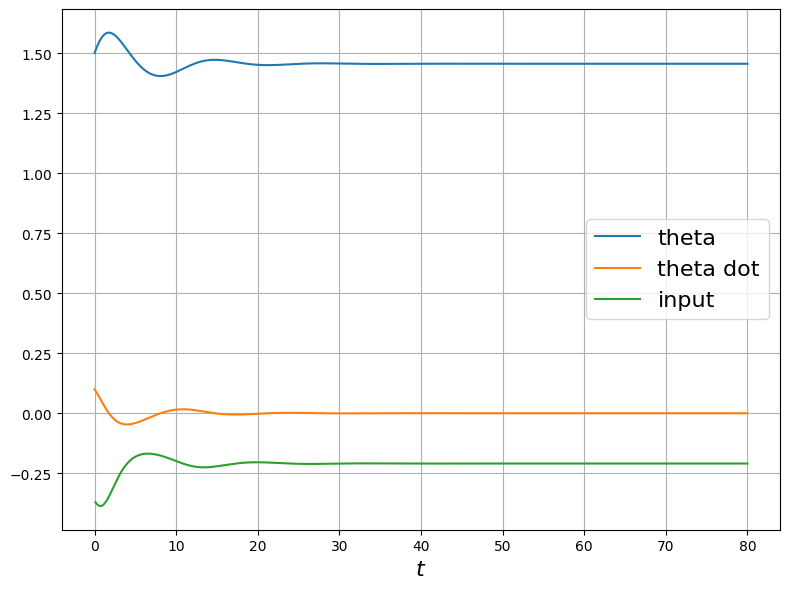

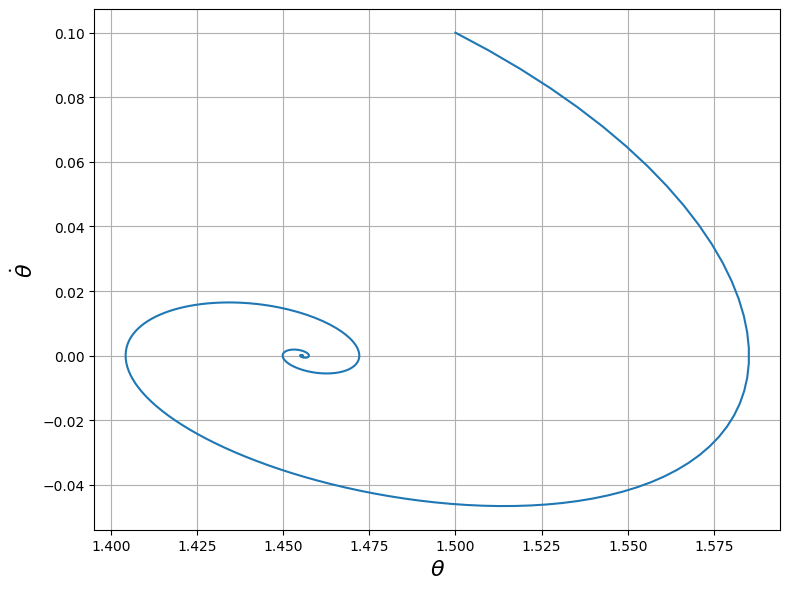

In [5]:
main()